# Outlier Function

This notebook creates the necessary functionalities for an outlier function to be integrated into the [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/) package. The function will allow to choose between two clustering methods for outlier detection:

- DBSCAN
- K-means

In [1]:
# import the necessary packages
# Base packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import random

# Pyleoclim for integration
import pyleoclim as pyleo

# The magic 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Function creation

The following functions are low-level functionalities to perform the calculations and will be incoroporated in the tsutils module:

In [29]:
def calculate_distances(ys, n_neighbors=None):
    '''
    '''
    
    ys=pyleo.utils.tsutils.standardize(ys)[0]
    ys=np.array(ys)
    
    if n_neighbors is None:
        # Lowest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        if min_eps<=0:
            min_eps=0.01
    
        # Highest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=len(ys)-1)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        max_eps = np.max(distances)
    
    else:
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        max_eps = np.max(distances)
    
    return min_eps, max_eps

def detect_outliers_DBSCAN(ys, nbr_clusters = None, eps=None, min_samples=None, n_neighbors=None, metric='euclidean'):
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    if eps is None:
        min_eps,max_eps = calculate_distances(ys, n_neighbors=n_neighbors)       
        eps_list = np.linspace(min_eps,max_eps,50)
    elif type(eps) is list:
        eps_list=eps
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        eps_list=list(eps)
    
    if min_samples is None:
        min_samples_list = np.linspace(2,len(ys)/4,50,dtype='int')
    elif type(min_samples) is list:
        min_samples_list = min_samples
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        min_samples_list=list(min_samples)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    
    nbr_clusters=[]
    sil_score =[]
    eps_matrix=[]
    min_sample_matrix=[]
    idx_out = []
    clusters = []

    for eps_item in eps_list:
        for min_samples_item in min_samples_list:
            eps_matrix.append(eps_item)
            min_sample_matrix.append(min_samples_item)
            m = DBSCAN(eps=eps_item, min_samples=min_samples_item)
            m.fit(ys.reshape(-1,1))
            nbr_clusters.append(len(np.unique(m.labels_))-1)
            try:
                sil_score.append(silhouette_score(ys.reshape(-1,1), m.labels_))
            except:
                sil_score.append(np.nan)
            idx_out.append(np.where(m.labels_==-1)[0])
            clusters.append(m.labels_)
            
    res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score,'outlier indices':idx_out,'clusters':clusters})
    
    if nbr_clusters is None: 
        res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
    else:
        res_cl = res.loc[res['number of clusters']==nbr_clusters]
        res_sil = res_cl.loc[res_cl['silhouette score']==np.max(res_cl['silhouette score'])]
    
    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def detect_outliers_kmeans(ys, nbr_cluster = None, max_cluster = 10, threshold=3):
    
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    # run with either one cluster number of several
    if nbr_cluster is not None:
        if type(nbr_cluster) == list:
            range_n_clusters = nbr_cluster
        else:
            range_n_clusters = [nbr_cluster]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    clusters = []
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1))
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
        clusters.append(kmeans.labels_)
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out,'clusters':clusters})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

In [ ]:
def plot_outliers(ts,ys,indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    if np.size(indices) != 0:
        pyleo.utils.plotting.plot_scatter_xy(ts,ys,ts[indices],ys[indices],ax=ax)
    else:
        pyleo.utils.plotting.plot_xy(ts,ys,ax=ax)

def plot_clusters(ts, ys, clusters, indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    color_list = list(mcolors.CSS4_COLORS.keys())
    color_list.remove('red')
    random.Random(9).shuffle(color_list)
    colors = color_list[0:len(np.unique(clusters))] 
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(ts, ys, c=vectorizer(clusters))
    if np.size(indices) != 0:
        plt.scatter(ts[indices],ys[indices],c='red')
    plt.show()

In [30]:
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=1000,seed=1983)
ys= pyleo.utils.tsutils.standardize(v)[0]
ys=np.array(ys)
ys

array([ 5.63480198e-01,  2.92869372e-01, -4.36414058e-01, -1.21169916e-01,
       -3.40454588e-01, -2.22424531e-01,  1.30886465e-01, -3.09308129e-01,
       -8.04521181e-02, -1.48340170e-01,  7.42910054e-01,  1.58985852e+00,
        5.37750936e-01,  4.42750726e-01,  1.65423989e+00,  1.86982698e+00,
        1.27002111e+00,  1.76267821e+00,  1.44603610e+00,  1.33487996e+00,
        1.98620020e+00,  1.89253143e+00,  1.41790069e+00,  2.03571157e+00,
        1.57390438e+00,  1.41520664e+00,  6.23376471e-01,  1.29768655e+00,
        3.82108868e-01,  5.98518260e-01, -2.03773275e-01,  6.47646338e-01,
        6.13399814e-01,  7.74109670e-01,  6.79910338e-01,  6.39662852e-03,
        3.46876312e-01,  4.61642555e-01,  1.54936421e+00,  3.39237013e-01,
        1.43564460e-01,  7.90699464e-01,  4.50591223e-01,  1.66730388e+00,
        1.71756748e+00,  1.30436051e+00,  9.18877912e-01,  7.92722529e-01,
        1.74350773e+00,  7.02547334e-01,  8.92567537e-01,  8.09641668e-01,
        5.07441686e-01,  

In [31]:
eps=estimate_eps(ys)
m = DBSCAN(eps=eps, min_samples=10,metric='euclidean') 
model = m.fit(ys.reshape(-1,1))

In [35]:
len(model.labels_)

1000

In [3]:
class Series(pyleo.Series):
    def outliers(self,method='kmeans',remove=True, settings=None,fig_outliers=True,figsize=[10,4],plot_kwargs=None,savefig_settings=None):
        
        if method not in ['kmeans','DBSCAN']:
            raise ValueError('method should either be "kmeans" or "DBSCAN"')
        
        # run the algorithm
        settings = {} if settings is None else settings.copy()
        savefig_settings = {} if savefig_settings is None else savefig_settings.copy()
        spec_func={
            'kmeans':detect_outliers_kmeans,
            'DBSCAN':detect_outliers_DBSCAN}
        args = {}
        args['kmeans'] = {}
        args['DBSCAN'] = {}
        args[method].update(settings)
        
        indices = spec_func[method](self.value,**args[method])
        
        new=self.copy()        
        if remove==True:
            ts,ys=remove_outliers(self.time,self.value,indices)
            new.value=ys
            new.time=ts
        
        if fig_outliers == True:
            fig,ax = plt.subplots(figsize=figsize)
            pyleo.utils.plotting.plot_scatter_xy(self.time,self.value,self.time[indices],self.value[indices],xlabel=self.time_unit,ylabel=self.value_unit,plot_kwargs=plot_kwargs,ax=ax)
            if 'path' in savefig_settings:
                pyleo.utils.plotting.savefig(fig,settings=savefig_settings)
        
        return new  

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

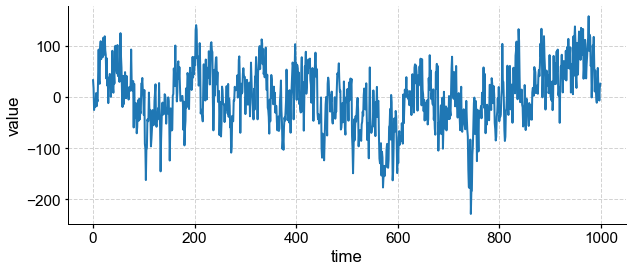

In [4]:
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=1000,seed=1983)
ts=Series(time=t,value=v)
ts.plot()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

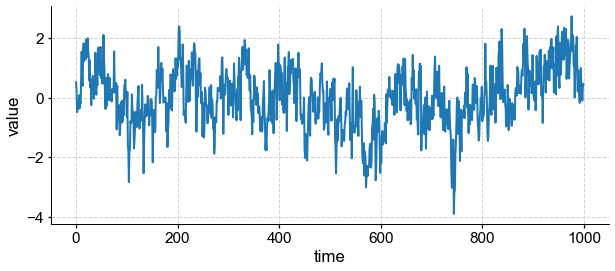

In [5]:
ts_new=ts.detrend().standardize()
ts_new.plot()

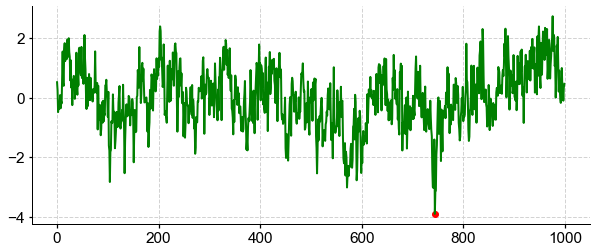

In [6]:
ts_out=ts_new.outliers()

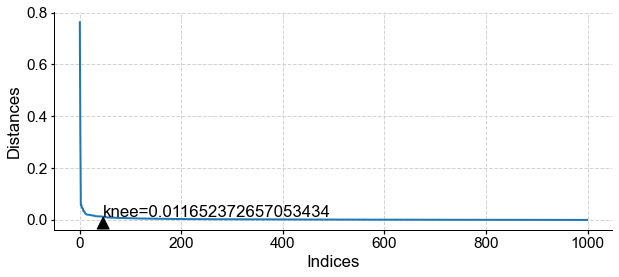

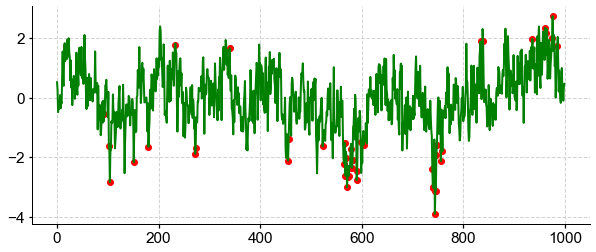

In [21]:
ts_out=ts_new.outliers(method='DBSCAN', settings={'fig_knee':True})